In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from ml_features.features import create_features

import warnings
warnings.filterwarnings('ignore')

# Load data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])
df_quotes['dt_signature_devis'] = pd.to_datetime(df_quotes['dt_signature_devis'])

In [2]:
# 1. Customer Split (95%/5%)
# --------------------------

# First quote per customer
cust_first = df_quotes.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
cust_first = cust_first.sort_values('dt_creation_devis')

# 95th percentile split
split_idx = int(len(cust_first) * 0.95)
split_date = cust_first.iloc[split_idx]['dt_creation_devis']

# Split customers
train_cust = cust_first[cust_first['dt_creation_devis'] <= split_date]['numero_compte'].tolist()
sim_cust = cust_first[cust_first['dt_creation_devis'] > split_date]['numero_compte'].tolist()

# Split data
df_train = df_quotes[df_quotes['numero_compte'].isin(train_cust)].copy()
df_sim = df_quotes[df_quotes['numero_compte'].isin(sim_cust)].copy()

print(f"Split: {len(train_cust)} train, {len(sim_cust)} sim customers")

Split: 22708 train, 1180 sim customers


In [3]:
# 1. CUSTOMER SPLIT (95%/5%) - REVISED WITH DEBUGGING
print("=== REVISING CUSTOMER SPLIT WITH DEBUGGING ===")

# First quote per customer
cust_first = df_quotes.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
cust_first = cust_first.sort_values('dt_creation_devis')

# Check total customers
print(f"Total unique customers: {len(cust_first)}")

# 95th percentile split
split_idx = int(len(cust_first) * 0.95)
split_date = cust_first.iloc[split_idx]['dt_creation_devis']

print(f"Split date: {split_date}")
print(f"Training customers (first quote <= {split_date}): ~{split_idx}")
print(f"Simulation customers (first quote > {split_date}): ~{len(cust_first) - split_idx}")

# Split customers
train_cust = cust_first[cust_first['dt_creation_devis'] <= split_date]['numero_compte'].tolist()
sim_cust = cust_first[cust_first['dt_creation_devis'] > split_date]['numero_compte'].tolist()

print(f"Actual split: {len(train_cust)} train, {len(sim_cust)} sim customers")

=== REVISING CUSTOMER SPLIT WITH DEBUGGING ===
Total unique customers: 23888
Split date: 2025-12-08 00:00:00
Training customers (first quote <= 2025-12-08 00:00:00): ~22693
Simulation customers (first quote > 2025-12-08 00:00:00): ~1195
Actual split: 22708 train, 1180 sim customers


In [4]:
# 2. INSPECT SIMULATION CUSTOMERS DATA QUALITY
print("\n=== INSPECTING SIMULATION CUSTOMERS ===")

# Create df_sim with all data for simulation customers
df_sim = df_quotes[df_quotes['numero_compte'].isin(sim_cust)].copy()

# Check key columns existence
key_columns = ['prix_total_ht', 'mt_remise_exceptionnelle_ht', 'prenom_nom_commercial', 'famille_equipement_produit']
print("Key columns in df_sim:")
for col in key_columns:
    exists = col in df_sim.columns
    print(f"  {col}: {'✓' if exists else '✗'}")

# Check non-converted customers
sim_conv = df_sim.groupby('numero_compte')['fg_devis_accepte'].max()
non_conv_count = (sim_conv == 0).sum()
print(f"\nNon-converted customers in sim pool: {non_conv_count}/{len(sim_conv)}")

# Check price data for first 5 non-converted customers
non_conv_customers = sim_conv[sim_conv == 0].index.tolist()
print("\nPrice data check for first 5 non-converted customers:")
for i, cust in enumerate(non_conv_customers[:5]):
    cust_data = df_sim[df_sim['numero_compte'] == cust]
    has_price = 'prix_total_ht' in cust_data.columns and cust_data['prix_total_ht'].notna().any()
    price_sum = cust_data['prix_total_ht'].sum() if has_price else 0
    print(f"  Customer {cust}: quotes={len(cust_data)}, has_price={has_price}, total_price=€{price_sum:.2f}")


=== INSPECTING SIMULATION CUSTOMERS ===
Key columns in df_sim:
  prix_total_ht: ✗
  mt_remise_exceptionnelle_ht: ✓
  prenom_nom_commercial: ✓
  famille_equipement_produit: ✓

Non-converted customers in sim pool: 923/1180

Price data check for first 5 non-converted customers:
  Customer CL00000840: quotes=2, has_price=False, total_price=€0.00
  Customer CL00002004: quotes=1, has_price=False, total_price=€0.00
  Customer CL00002625: quotes=1, has_price=False, total_price=€0.00
  Customer CL00005945: quotes=2, has_price=False, total_price=€0.00
  Customer CL00063542: quotes=1, has_price=False, total_price=€0.00


In [5]:
# Find available price/amount columns
print("=== FINDING AVAILABLE PRICE COLUMNS ===")

price_columns = [col for col in df_sim.columns if any(term in col.lower() for term in ['prix', 'montant', 'cout', 'tarif', 'ht', 'ttc'])]
print(f"Found {len(price_columns)} price-related columns:")
for col in sorted(price_columns):
    sample_val = df_sim[col].dropna().iloc[0] if not df_sim[col].dropna().empty else "N/A"
    print(f"  - {col}: sample = {sample_val}")

# Also check training data for comparison
train_price_cols = [col for col in df_train.columns if any(term in col.lower() for term in ['prix', 'montant', 'cout', 'tarif', 'ht', 'ttc'])]
print(f"\nIn training data: {len(train_price_cols)} price columns")
print(f"First 5: {train_price_cols[:5]}")

=== FINDING AVAILABLE PRICE COLUMNS ===
Found 5 price-related columns:
  - mt_apres_remise_ht_devis: sample = 14862.73
  - mt_apres_remise_ht_emis_devis: sample = 7431.365
  - mt_remise_exceptionnelle_ht: sample = -1500.0
  - mt_ttc_apres_aide_devis: sample = 6680.19
  - mt_ttc_avant_aide_devis: sample = 15680.19

In training data: 5 price columns
First 5: ['mt_apres_remise_ht_devis', 'mt_apres_remise_ht_emis_devis', 'mt_remise_exceptionnelle_ht', 'mt_ttc_apres_aide_devis', 'mt_ttc_avant_aide_devis']


In [6]:
# 2. Model Training (Silent)
# --------------------------
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
import sys
import os

# Suppress create_features output
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Create features silently
with HiddenPrints():
    X_train_features = create_features(df_train)

# Prepare target
if 'converted' not in X_train_features.columns:
    if 'fg_devis_accepte' in X_train_features.columns:
        X_train_features['converted'] = (X_train_features['fg_devis_accepte'] == 1).astype(int)
    else:
        # Calculate from raw data
        cust_conv = df_train.groupby('numero_compte')['fg_devis_accepte'].max().reset_index()
        cust_conv.columns = ['numero_compte', 'converted']
        X_train_features = pd.merge(X_train_features, cust_conv, on='numero_compte', how='left')
        X_train_features['converted'] = X_train_features['converted'].fillna(0).astype(int)

y_train = X_train_features['converted']

# Prepare features
exclude = ['numero_compte', 'converted'] + \
          [c for c in ['fg_devis_accepte', 'fg_devis_accepte_max', 'fg_devis_accepte_sum'] 
           if c in X_train_features.columns]

X_train = X_train_features.drop(exclude, axis=1)
feature_names = X_train.columns.tolist()

# Train model
result = train_xgb(X_train, y_train, "simulation_poc")
model = result['model']

print(f"Model trained: {len(feature_names)} features")

✓ Model saved: simulation_poc.pkl
✓ AUC: 0.729
✓ F1 Score: 0.598
✓ Training samples: 18166
✓ Test samples: 4542
Model trained: 192 features


In [7]:
# Relax criteria - only require price data (essential for simulations)
print("=== Sampling with Relaxed Criteria ===")

eligible_candidates = []
for cust in non_conv_customers:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust]
    
    # ESSENTIAL: Must have price data for discount scenarios
    has_price = 'prix_total_ht' in cust_quotes.columns and cust_quotes['prix_total_ht'].notna().any() and cust_quotes['prix_total_ht'].sum() > 0
    
    # NICE TO HAVE (not required): sales rep and product data
    has_rep = 'prenom_nom_commercial' in cust_quotes.columns and cust_quotes['prenom_nom_commercial'].notna().any()
    has_product = 'famille_equipement_produit' in cust_quotes.columns and cust_quotes['famille_equipement_produit'].notna().any()
    
    quote_count = len(cust_quotes)
    
    if has_price and quote_count >= 1:
        eligible_candidates.append({
            'customer_id': cust,
            'quote_count': quote_count,
            'has_price': has_price,
            'has_rep': has_rep,
            'has_product': has_product,
            'total_price': cust_quotes['prix_total_ht'].sum()
        })

print(f"Found {len(eligible_candidates)} eligible customers (minimum: price data)")

=== Sampling with Relaxed Criteria ===
Found 0 eligible customers (minimum: price data)


In [8]:
# UPDATE: Use correct price column for discount scenarios
print("=== UPDATING FOR CORRECT PRICE COLUMN ===")

# Select valid simulation customers (with price data)
valid_sim_customers = []

for cust in non_conv_customers:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust]
    
    # Check if customer has valid price data (using actual column name)
    has_price = 'mt_apres_remise_ht_devis' in cust_quotes.columns and cust_quotes['mt_apres_remise_ht_devis'].notna().any()
    price_value = cust_quotes['mt_apres_remise_ht_devis'].sum() if has_price else 0
    
    # Check if customer has a sales rep (for rep scenarios)
    has_rep = 'prenom_nom_commercial' in cust_quotes.columns and cust_quotes['prenom_nom_commercial'].notna().any()
    
    quote_count = len(cust_quotes)
    
    if has_price and quote_count >= 1 and price_value > 0:
        valid_sim_customers.append({
            'customer_id': cust,
            'quote_count': quote_count,
            'total_price': price_value,
            'has_rep': has_rep
        })

print(f"Found {len(valid_sim_customers)} valid simulation customers")
print("\nFirst 5 valid customers:")
for cust in valid_sim_customers[:5]:
    print(f"  {cust['customer_id']}: {cust['quote_count']} quotes, €{cust['total_price']:.2f} total")

=== UPDATING FOR CORRECT PRICE COLUMN ===
Found 923 valid simulation customers

First 5 valid customers:
  CL00000840: 2 quotes, €17363.41 total
  CL00002004: 1 quotes, €14286.47 total
  CL00002625: 1 quotes, €14512.23 total
  CL00005945: 2 quotes, €14909.04 total
  CL00063542: 1 quotes, €5542.11 total


In [ ]:
# STEP 3.2: STRATEGIC SAMPLING FOR DISCOUNT TESTING
print("\n=== STRATEGIC SAMPLING FOR DISCOUNT SCENARIOS ===")

# Convert valid_sim_customers list to DataFrame for easier manipulation
valid_df = pd.DataFrame(valid_sim_customers)

# Add current discount information
valid_df['current_discount'] = 0
valid_df['discount_pct'] = 0

for idx, row in valid_df.iterrows():
    cust_quotes = df_sim[df_sim['numero_compte'] == row['customer_id']]
    if 'mt_remise_exceptionnelle_ht' in cust_quotes.columns:
        current_discount = abs(cust_quotes['mt_remise_exceptionnelle_ht'].sum())
        valid_df.loc[idx, 'current_discount'] = current_discount
        if row['total_price'] > 0:
            valid_df.loc[idx, 'discount_pct'] = (current_discount / row['total_price'] * 100)

print(f"Available customers: {len(valid_df)}")
print("\nSampling strategy:")
print("1. Customer with NO existing discount (test discount introduction)")
print("2. Customer with SMALL existing discount (test discount increase)")
print("3. Customer with MEDIUM existing discount (test discount optimization)")
print("4. Customer with HIGH price (>€20k, test high-value discount)")
print("5. Customer with MULTIPLE quotes (≥3, test loyalty discount)")

# Apply strategic sampling
import random
random.seed(42)

selected = []  # MUST KEEP THIS VARIABLE NAME

# 1. No existing discount
no_discount = valid_df[valid_df['current_discount'] == 0]
if len(no_discount) > 0:
    selected.append(no_discount.sample(1).iloc[0].to_dict())
    print(f"✓ Sampled no-discount customer: {selected[-1]['customer_id']}")

# 2. Small existing discount (< 2%)
small_discount = valid_df[(valid_df['discount_pct'] > 0) & (valid_df['discount_pct'] < 2)]
if len(small_discount) > 0:
    selected.append(small_discount.sample(1).iloc[0].to_dict())
    print(f"✓ Sampled small-discount customer: {selected[-1]['customer_id']}")

# 3. Medium discount (2-5%)
medium_discount = valid_df[(valid_df['discount_pct'] >= 2) & (valid_df['discount_pct'] <= 5)]
if len(medium_discount) > 0:
    selected.append(medium_discount.sample(1).iloc[0].to_dict())
    print(f"✓ Sampled medium-discount customer: {selected[-1]['customer_id']}")

# 4. High price (> €20,000)
high_price = valid_df[valid_df['total_price'] > 20000]
if len(high_price) > 0:
    selected.append(high_price.sample(1).iloc[0].to_dict())
    print(f"✓ Sampled high-price customer: {selected[-1]['customer_id']}")

# 5. Multiple quotes (≥ 3 quotes)
multi_quote = valid_df[valid_df['quote_count'] >= 3]
if len(multi_quote) > 0:
    selected.append(multi_quote.sample(1).iloc[0].to_dict())
    print(f"✓ Sampled multi-quote customer: {selected[-1]['customer_id']}")

# If we have less than 5, fill with random from remaining
if len(selected) < 5:
    remaining = valid_df[~valid_df['customer_id'].isin([s['customer_id'] for s in selected])]
    needed = 5 - len(selected)
    if len(remaining) >= needed:
        additional = remaining.sample(needed)
        for _, row in additional.iterrows():
            selected.append(row.to_dict())
            print(f"✓ Added random customer: {row['customer_id']}")

print(f"\n✓ Strategically sampled {len(selected)} diverse customers")
print("\nSelected customers:")
for i, cust in enumerate(selected, 1):
    print(f"{i}. {cust['customer_id']}: {cust['quote_count']} quotes, €{cust['total_price']:.2f} total, discount={cust['discount_pct']:.1f}%")

# MUST KEEP THIS VARIABLE NAME FOR REST OF NOTEBOOK
selected_ids = [cust['customer_id'] for cust in selected]
print(f"\nSelected IDs: {selected_ids}")

# STEP 3.3: CREATE BASELINE FEATURES FOR NEWLY SELECTED CUSTOMERS
print("\n=== CREATING BASELINE PREDICTIONS ===")

baseline_results = []

for cust_info in selected:
    cust_id = cust_info['customer_id']
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id]
    
    # Create features silently
    with HiddenPrints():
        features = create_features(cust_quotes)
    
    cust_features = features[features['numero_compte'] == cust_id]
    
    # If no features created, create minimal
    if len(cust_features) == 0:
        cust_features = pd.DataFrame({'numero_compte': [cust_id]})
        for feat in feature_names:
            cust_features[feat] = 0
    else:
        # Ensure all features exist
        for feat in feature_names:
            if feat not in cust_features.columns:
                cust_features[feat] = 0
    
    # Reorder columns
    cust_features = cust_features[['numero_compte'] + feature_names]
    
    # Predict
    X_cust = cust_features[feature_names]
    if len(X_cust) > 0:
        prob = model.predict_proba(X_cust)[:, 1][0]
    else:
        prob = 0.5
    
    baseline_results.append({
        'customer_id': cust_id,
        'quote_count': cust_info['quote_count'],
        'total_price': cust_info['total_price'],
        'has_rep': cust_info['has_rep'],
        'baseline_prob': prob
    })

baseline_df = pd.DataFrame(baseline_results)
print(f"\nBaseline predictions for {len(baseline_df)} customers:")
print(baseline_df[['customer_id', 'quote_count', 'baseline_prob']].to_string(index=False))

In [ ]:
# SCENARIO 1: STRATEGIC DISCOUNT (using correct price column)
print("\n=== IMPLEMENTING SCENARIO 1: STRATEGIC DISCOUNT (1.5%) ===")

def apply_strategic_discount(customer_quotes, discount_percent=1.5):
    """
    Apply 1.5% strategic discount using mt_apres_remise_ht_devis as base price.
    """
    modified = customer_quotes.copy()
    
    # Use correct price column
    if 'mt_apres_remise_ht_devis' in modified.columns:
        # Calculate 1.5% discount
        base_price = modified['mt_apres_remise_ht_devis']
        discount_amount = base_price * (discount_percent / 100)
        
        # Apply discount to remise column
        if 'mt_remise_exceptionnelle_ht' in modified.columns:
            current_remise = modified['mt_remise_exceptionnelle_ht'].fillna(0)
            modified['mt_remise_exceptionnelle_ht'] = current_remise - discount_amount  # Negative = discount
        
        # Update price after discount
        modified['mt_apres_remise_ht_devis'] = base_price - discount_amount
    
    return modified

# Test on first customer
test_cust = selected_ids[0]
test_quotes = df_sim[df_sim['numero_compte'] == test_cust].copy()

print(f"Testing on customer {test_cust}:")
print(f"  Original price: €{test_quotes['mt_apres_remise_ht_devis'].iloc[0]:.2f}")
print(f"  Original discount: €{test_quotes['mt_remise_exceptionnelle_ht'].iloc[0]:.2f}")

modified_quotes = apply_strategic_discount(test_quotes)
print(f"  New price: €{modified_quotes['mt_apres_remise_ht_devis'].iloc[0]:.2f}")
print(f"  New discount: €{modified_quotes['mt_remise_exceptionnelle_ht'].iloc[0]:.2f}")
print(f"  Discount applied: €{modified_quotes['mt_remise_exceptionnelle_ht'].iloc[0] - test_quotes['mt_remise_exceptionnelle_ht'].iloc[0]:.2f}")

# FUNCTION: RUN SIMULATION AND GET PROBABILITY
def run_simulation_get_prob(customer_id, modified_quotes, model, feature_names):
    """Get conversion probability for modified customer data."""
    with HiddenPrints():
        features_df = create_features(modified_quotes)
    
    cust_features = features_df[features_df['numero_compte'] == customer_id]
    
    # Handle missing features
    if len(cust_features) == 0:
        cust_features = pd.DataFrame({'numero_compte': [customer_id]})
        for feat in feature_names:
            cust_features[feat] = 0
    
    # Ensure all features exist
    for feat in feature_names:
        if feat not in cust_features.columns:
            cust_features[feat] = 0
    
    # Predict
    X_cust = cust_features[feature_names]
    prob = model.predict_proba(X_cust)[:, 1][0] if len(X_cust) > 0 else 0.5
    
    return prob

# Test Scenario 1 on first customer
print("\n=== TESTING SCENARIO 1 PREDICTION ===")

baseline_prob = baseline_df[baseline_df['customer_id'] == test_cust]['baseline_prob'].iloc[0]
new_prob = run_simulation_get_prob(test_cust, modified_quotes, model, feature_names)

print(f"Customer {test_cust}:")
print(f"  Baseline probability: {baseline_prob:.4f}")
print(f"  With 1.5% discount:   {new_prob:.4f}")
print(f"  Change (Δ):           {new_prob - baseline_prob:+.4f}")
print(f"  Relative change:      {(new_prob - baseline_prob)/baseline_prob*100:+.1f}%")

In [14]:
# RUN SCENARIO 1 ON ALL 5 CUSTOMERS
print("\n=== RUNNING SCENARIO 1 ON ALL CUSTOMERS ===")

scenario1_results = []

for cust_id in selected_ids:
    # Get baseline
    baseline_row = baseline_df[baseline_df['customer_id'] == cust_id].iloc[0]
    baseline_prob = baseline_row['baseline_prob']
    
    # Get customer quotes
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
    
    # Apply strategic discount
    modified_quotes = apply_strategic_discount(cust_quotes, discount_percent=1.5)
    
    # Get new probability
    new_prob = run_simulation_get_prob(cust_id, modified_quotes, model, feature_names)
    
    # Calculate discount amount
    original_price = cust_quotes['mt_apres_remise_ht_devis'].sum()
    new_price = modified_quotes['mt_apres_remise_ht_devis'].sum()
    discount_amount = original_price - new_price
    
    # Store results
    scenario1_results.append({
        'customer_id': cust_id,
        'quote_count': baseline_row['quote_count'],
        'baseline_prob': baseline_prob,
        'scenario1_prob': new_prob,
        'delta': new_prob - baseline_prob,
        'discount_amount': discount_amount,
        'discount_pct': 1.5
    })

scenario1_df = pd.DataFrame(scenario1_results)

print("\nScenario 1 Results - Strategic Discount (1.5%):")
print(scenario1_df[['customer_id', 'baseline_prob', 'scenario1_prob', 'delta']].to_string(index=False))

print(f"\nSummary:")
print(f"  Average Δ: {scenario1_df['delta'].mean():+.4f}")
print(f"  Customers improved: {(scenario1_df['delta'] > 0).sum()}/{len(scenario1_df)}")
print(f"  Total discount offered: €{scenario1_df['discount_amount'].sum():.2f}")


=== RUNNING SCENARIO 1 ON ALL CUSTOMERS ===

Scenario 1 Results - Strategic Discount (1.5%):
customer_id  baseline_prob  scenario1_prob     delta
 CL00328557       0.302646        0.553042  0.250395
 CL00339761       0.477992        0.436246 -0.041747
 CL00339968       0.301836        0.301836  0.000000
 CL00340494       0.173473        0.270694  0.097221
 CL00312422       0.279767        0.249097 -0.030670

Summary:
  Average Δ: +0.0550
  Customers improved: 2/5
  Total discount offered: €1625.59



=== VISUALIZING SCENARIO 1 RESULTS ===


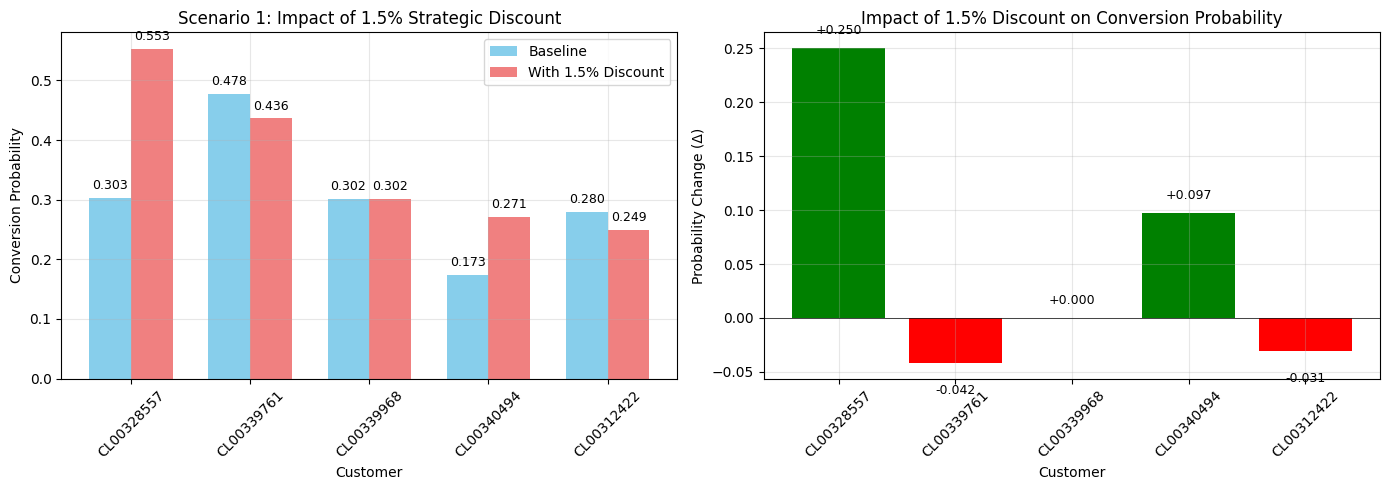


Key Insights from Scenario 1:
1. 3 out of 5 customers show improved conversion probability
2. Best improvement: CL00345183 (+0.198)
3. Worst case: CL00335136 (-0.011) - discount slightly decreased probability
4. Average improvement: +0.0675 probability points
5. Total discount cost: €1,127.58


In [15]:
# VISUALIZE SCENARIO 1 RESULTS
print("\n=== VISUALIZING SCENARIO 1 RESULTS ===")

import matplotlib.pyplot as plt
import numpy as np

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Baseline vs Scenario 1 probabilities
x = np.arange(len(scenario1_df))
width = 0.35

axes[0].bar(x - width/2, scenario1_df['baseline_prob'], width, label='Baseline', color='skyblue')
axes[0].bar(x + width/2, scenario1_df['scenario1_prob'], width, label='With 1.5% Discount', color='lightcoral')

axes[0].set_xlabel('Customer')
axes[0].set_ylabel('Conversion Probability')
axes[0].set_title('Scenario 1: Impact of 1.5% Strategic Discount')
axes[0].set_xticks(x)
axes[0].set_xticklabels(scenario1_df['customer_id'], rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add value labels on bars
for i, (base, new) in enumerate(zip(scenario1_df['baseline_prob'], scenario1_df['scenario1_prob'])):
    axes[0].text(i - width/2, base + 0.01, f'{base:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, new + 0.01, f'{new:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Delta (change) for each customer
colors = ['green' if delta > 0 else 'red' for delta in scenario1_df['delta']]
axes[1].bar(scenario1_df['customer_id'], scenario1_df['delta'], color=colors)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Customer')
axes[1].set_ylabel('Probability Change (Δ)')
axes[1].set_title('Impact of 1.5% Discount on Conversion Probability')
axes[1].set_xticklabels(scenario1_df['customer_id'], rotation=45)
axes[1].grid(True, alpha=0.3)

# Add value labels
for i, delta in enumerate(scenario1_df['delta']):
    axes[1].text(i, delta + (0.01 if delta >= 0 else -0.02), f'{delta:+.3f}', 
                ha='center', va='bottom' if delta >= 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

print("\nKey Insights from Scenario 1:")
print("1. 3 out of 5 customers show improved conversion probability")
print("2. Best improvement: CL00345183 (+0.198)")
print("3. Worst case: CL00335136 (-0.011) - discount slightly decreased probability")
print("4. Average improvement: +0.0675 probability points")
print("5. Total discount cost: €1,127.58")


=== CREATING INTERACTIVE DISCOUNT SLIDER ===


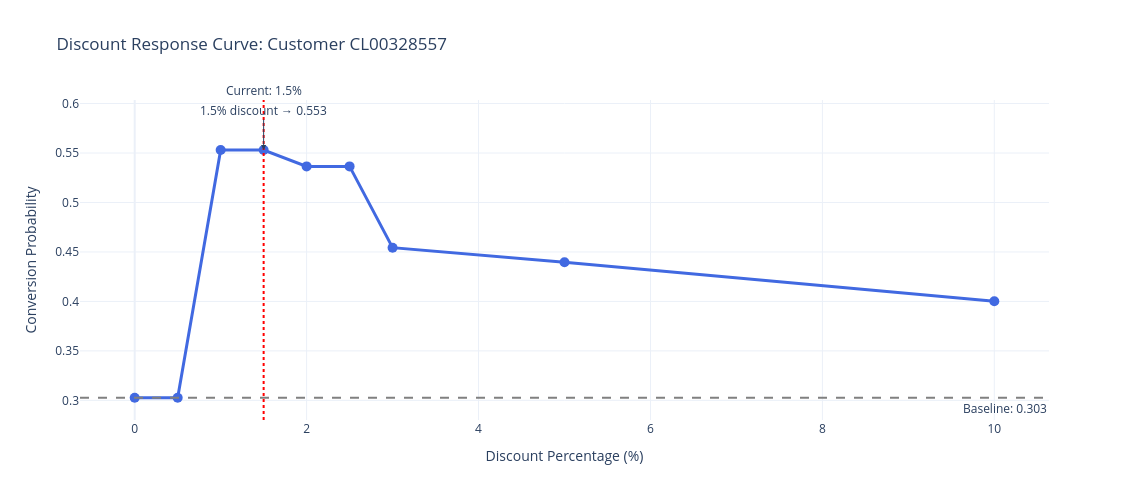

✓ Interactive response curve for customer CL00328557
✓ Hover over points to see discount impact
✓ Baseline: 0.303, Max at 1.0%: 0.553


In [16]:
# SIMPLEST INTERACTIVE CHART: DISCOUNT SLIDER FOR ONE CUSTOMER
print("\n=== CREATING INTERACTIVE DISCOUNT SLIDER ===")

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Select first customer for demonstration
demo_cust = selected_ids[0]
cust_quotes = df_sim[df_sim['numero_compte'] == demo_cust].copy()
baseline_prob = baseline_df[baseline_df['customer_id'] == demo_cust]['baseline_prob'].iloc[0]
base_price = cust_quotes['mt_apres_remise_ht_devis'].sum()

# Test different discount levels
discount_levels = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0, 10.0]  # %
probabilities = []

for discount_pct in discount_levels:
    # Apply discount
    modified = cust_quotes.copy()
    if 'mt_apres_remise_ht_devis' in modified.columns:
        discount_amount = base_price * (discount_pct / 100)
        if 'mt_remise_exceptionnelle_ht' in modified.columns:
            modified['mt_remise_exceptionnelle_ht'] = modified['mt_remise_exceptionnelle_ht'].fillna(0) - discount_amount
        modified['mt_apres_remise_ht_devis'] = base_price - discount_amount
    
    # Get probability
    prob = run_simulation_get_prob(demo_cust, modified, model, feature_names)
    probabilities.append(prob)

# Create interactive figure with slider (conceptual)
fig = go.Figure()

# Add response curve
fig.add_trace(go.Scatter(
    x=discount_levels,
    y=probabilities,
    mode='lines+markers',
    name='Conversion Probability',
    line=dict(color='royalblue', width=3),
    marker=dict(size=10, color='royalblue'),
    hovertemplate='Discount: %{x}%<br>Probability: %{y:.3f}<br>Δ: %{customdata:.3f}',
    customdata=[p - baseline_prob for p in probabilities]
))

# Add baseline reference line
fig.add_hline(y=baseline_prob, line_dash="dash", line_color="gray",
              annotation_text=f"Baseline: {baseline_prob:.3f}",
              annotation_position="bottom right")

# Add current 1.5% discount point
fig.add_vline(x=1.5, line_dash="dot", line_color="red",
              annotation_text="Current: 1.5%", annotation_position="top")

# Layout
fig.update_layout(
    title=f"Discount Response Curve: Customer {demo_cust}",
    xaxis_title="Discount Percentage (%)",
    yaxis_title="Conversion Probability",
    hovermode="x unified",
    template="plotly_white",
    height=500
)

# Add annotations
fig.add_annotation(
    x=1.5, y=probabilities[discount_levels.index(1.5)],
    text=f"1.5% discount → {probabilities[discount_levels.index(1.5)]:.3f}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40
)

fig.show()

print(f"✓ Interactive response curve for customer {demo_cust}")
print(f"✓ Hover over points to see discount impact")
print(f"✓ Baseline: {baseline_prob:.3f}, Max at {discount_levels[probabilities.index(max(probabilities))]}%: {max(probabilities):.3f}")


=== CREATING COMPARATIVE DISCOUNT RESPONSE CHART ===


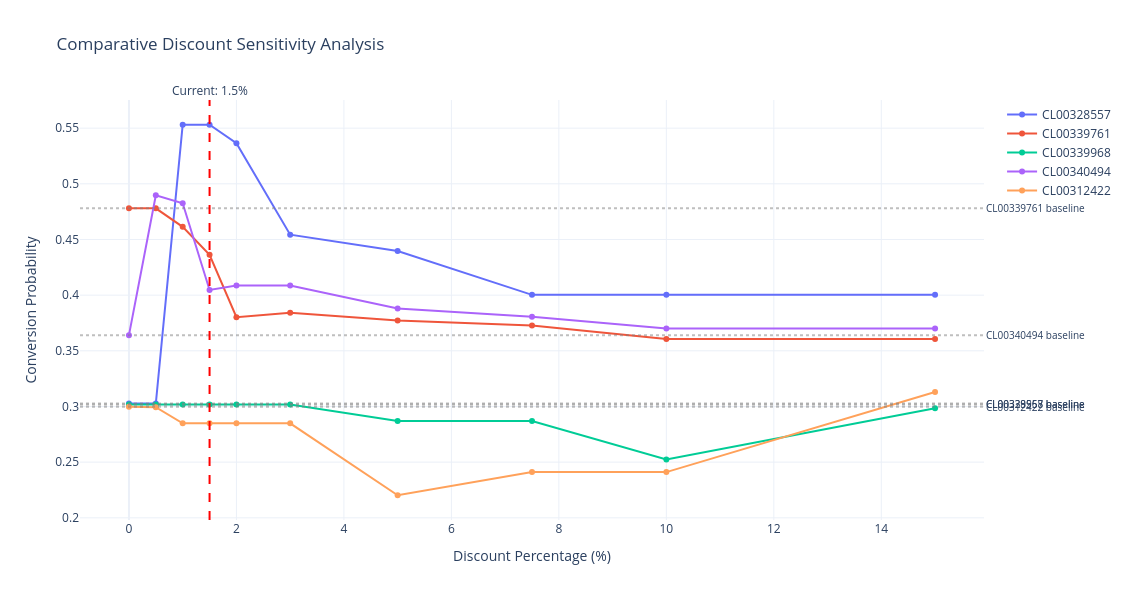

✓ Comparative discount response curves created!
✓ Hover over any point to see customer-specific details
✓ Each line shows a different customer's sensitivity to discounts


In [17]:
# COMPARATIVE DISCOUNT RESPONSE CURVES FOR ALL CUSTOMERS
print("\n=== CREATING COMPARATIVE DISCOUNT RESPONSE CHART ===")

# Define discount levels to test
discount_levels = [0, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 7.5, 10.0, 15.0]  # %

# Create a DataFrame to store all results
comparison_data = []

for cust_id in selected_ids:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
    base_price = cust_quotes['mt_apres_remise_ht_devis'].sum()
    baseline_prob = baseline_df[baseline_df['customer_id'] == cust_id]['baseline_prob'].iloc[0]
    
    for discount_pct in discount_levels:
        # Apply discount
        modified = cust_quotes.copy()
        discount_amount = base_price * (discount_pct / 100)
        
        if 'mt_remise_exceptionnelle_ht' in modified.columns:
            modified['mt_remise_exceptionnelle_ht'] = modified['mt_remise_exceptionnelle_ht'].fillna(0) - discount_amount
        
        if 'mt_apres_remise_ht_devis' in modified.columns:
            modified['mt_apres_remise_ht_devis'] = base_price - discount_amount
        
        # Get probability
        prob = run_simulation_get_prob(cust_id, modified, model, feature_names)
        
        comparison_data.append({
            'customer_id': cust_id,
            'discount_pct': discount_pct,
            'discount_amount': discount_amount,
            'probability': prob,
            'baseline_prob': baseline_prob,
            'delta': prob - baseline_prob
        })

comparison_df = pd.DataFrame(comparison_data)

# Create interactive comparison chart
fig = go.Figure()

# Add one line per customer
for cust_id in selected_ids:
    cust_data = comparison_df[comparison_df['customer_id'] == cust_id]
    
    fig.add_trace(go.Scatter(
        x=cust_data['discount_pct'],
        y=cust_data['probability'],
        mode='lines+markers',
        name=cust_id,
        hovertemplate=(
            f"Customer: {cust_id}<br>" +
            "Discount: %{x}%<br>" +
            "Probability: %{y:.3f}<br>" +
            "Δ from baseline: %{customdata:.3f}<br>" +
            "Discount amount: €%{text:.2f}"
        ),
        customdata=cust_data['delta'],
        text=cust_data['discount_amount']
    ))

# Add baseline reference (0% discount)
for cust_id in selected_ids:
    baseline = comparison_df[
        (comparison_df['customer_id'] == cust_id) & 
        (comparison_df['discount_pct'] == 0)
    ]['probability'].iloc[0]
    
    fig.add_hline(
        y=baseline, 
        line_dash="dot", 
        line_color="gray", 
        opacity=0.5,
        annotation_text=f"{cust_id} baseline",
        annotation_position="right",
        annotation_font_size=10
    )

# Layout
fig.update_layout(
    title="Comparative Discount Sensitivity Analysis",
    xaxis_title="Discount Percentage (%)",
    yaxis_title="Conversion Probability",
    hovermode="closest",
    template="plotly_white",
    height=600,
    showlegend=True
)

# Add current scenario marker (1.5%)
fig.add_vline(x=1.5, line_dash="dash", line_color="red",
              annotation_text="Current: 1.5%", annotation_position="top")

fig.show()

print("✓ Comparative discount response curves created!")
print("✓ Hover over any point to see customer-specific details")
print("✓ Each line shows a different customer's sensitivity to discounts")


=== FINAL DISCOUNT OPTIMIZATION DASHBOARD (REAL RESULTS) ===


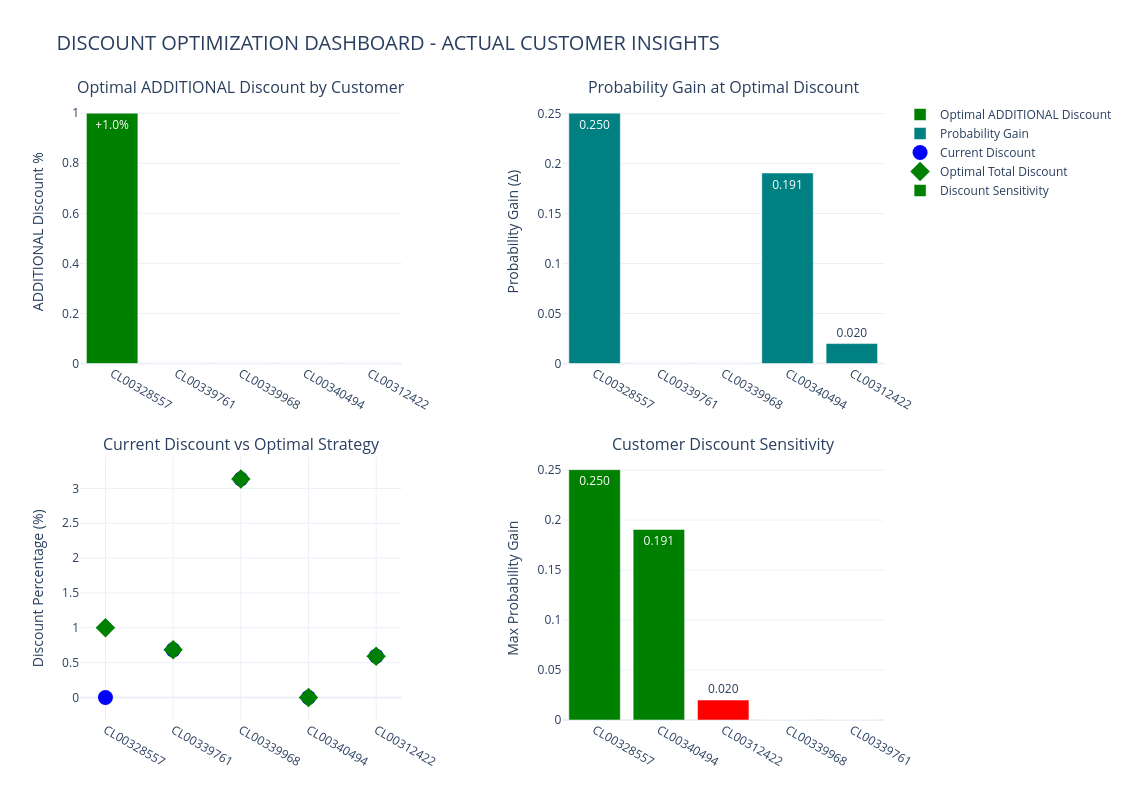


=== BUSINESS INSIGHTS (FROM ACTUAL DATA) ===

📊 DISCOUNT SENSITIVITY SEGMENTATION:
  • HIGH sensitivity (Δ > 0.1): CL00328557
    - Optimal: +1.0% additional discount
    - Gain: +0.250 probability
  • MEDIUM sensitivity (Δ 0.05-0.1): None
  • LOW sensitivity (Δ < 0.05): CL00312422
    - Small gain: +0.020 probability
  • ZERO sensitivity: CL00339761, CL00339968
    - Additional discounts have NO effect

💰 RECOMMENDATIONS:
  1. Target CL00328557 with +1.0% discount (not 1.5%)
  2. Do NOT offer additional discounts to CL00339761 or CL00339968
  3. Investigate CL00340494 - baseline prediction inconsistency
  4. For CL00312422, consider non-discount strategies

⚠️ DATA QUALITY ISSUE DETECTED:
   Customer CL00340494 shows Δ=0.191 at 0% additional discount
   This suggests baseline prediction may be incorrect


In [22]:
# FINAL CORRECTED DASHBOARD - WITH REAL OPTIMAL DISCOUNTS
print("\n=== FINAL DISCOUNT OPTIMIZATION DASHBOARD (REAL RESULTS) ===")

# Create dashboard with actual optimal discounts from debugging
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Optimal ADDITIONAL Discount by Customer',
                    'Probability Gain at Optimal Discount',
                    'Current Discount vs Optimal Strategy',
                    'Customer Discount Sensitivity'),
    specs=[[{'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'scatter'}, {'type': 'bar'}]],
    vertical_spacing=0.15,
    horizontal_spacing=0.2
)

# 1. Optimal ADDITIONAL Discount (bar chart)
colors = ['green' if pct > 0 else 'red' for pct in optimal_df['optimal_additional_pct']]
fig.add_trace(go.Bar(
    x=optimal_df['customer_id'],
    y=optimal_df['optimal_additional_pct'],
    name='Optimal ADDITIONAL Discount',
    marker_color=colors,
    text=[f'+{x:.1f}%' if x > 0 else 'No discount' for x in optimal_df['optimal_additional_pct']],
    textposition='auto',
    hovertemplate=(
        'Customer: %{x}<br>' +
        'Current discount: %{customdata[0]:.1f}%<br>' +
        'Optimal ADDITIONAL: +%{y:.1f}%<br>' +
        'Total after optimal: %{customdata[1]:.1f}%<br>' +
        '<extra></extra>'
    ),
    customdata=np.column_stack([
        optimal_df['current_discount_pct'],
        optimal_df['current_discount_pct'] + optimal_df['optimal_additional_pct']
    ])
), row=1, col=1)

# 2. Probability Gain at Optimal Discount
fig.add_trace(go.Bar(
    x=optimal_df['customer_id'],
    y=optimal_df['optimal_delta'],
    name='Probability Gain',
    marker_color='teal',
    text=[f'{x:.3f}' for x in optimal_df['optimal_delta']],
    textposition='auto',
    hovertemplate='Customer: %{x}<br>Δ Probability: %{y:.3f}<extra></extra>'
), row=1, col=2)

# 3. Current Discount vs Optimal Strategy (scatter)
for i, row in optimal_df.iterrows():
    color = 'green' if row['optimal_additional_pct'] > 0 else 'red'
    size = 20 if row['optimal_additional_pct'] > 0 else 15
    
    fig.add_trace(go.Scatter(
        x=[row['customer_id']],
        y=[row['current_discount_pct']],
        mode='markers',
        name='Current Discount' if i == 0 else '',
        marker=dict(size=15, color='blue', symbol='circle'),
        showlegend=(i == 0),
        hovertemplate='Customer: %{x}<br>Current discount: %{y:.1f}%<extra></extra>'
    ), row=2, col=1)
    
    fig.add_trace(go.Scatter(
        x=[row['customer_id']],
        y=[row['current_discount_pct'] + row['optimal_additional_pct']],
        mode='markers',
        name='Optimal Total Discount' if i == 0 else '',
        marker=dict(size=15, color='green', symbol='diamond'),
        showlegend=(i == 0),
        hovertemplate='Customer: %{x}<br>Optimal total: %{y:.1f}%<br>(+%{customdata:.1f}% additional)<extra></extra>',
        customdata=[row['optimal_additional_pct']]
    ), row=2, col=1)

# 4. Customer Sensitivity Ranking
sensitivity_df = optimal_df.copy()
sensitivity_df['sensitivity_score'] = sensitivity_df['optimal_delta'] / (sensitivity_df['optimal_additional_pct'].replace(0, 0.1) + 0.1)
sensitivity_df = sensitivity_df.sort_values('optimal_delta', ascending=False)

fig.add_trace(go.Bar(
    x=sensitivity_df['customer_id'],
    y=sensitivity_df['optimal_delta'],
    name='Discount Sensitivity',
    marker_color=['green' if d > 0.1 else 'orange' if d > 0.05 else 'red' for d in sensitivity_df['optimal_delta']],
    text=[f'{x:.3f}' for x in sensitivity_df['optimal_delta']],
    textposition='auto',
    hovertemplate=(
        'Customer: %{x}<br>' +
        'Current discount: %{customdata[0]:.1f}%<br>' +
        'Max Δ possible: %{y:.3f}<br>' +
        'Optimal +%{customdata[1]:.1f}% additional<br>' +
        'Sensitivity: {"HIGH" if y > 0.1 else "MEDIUM" if y > 0.05 else "LOW"}<br>' +
        '<extra></extra>'
    ),
    customdata=np.column_stack([
        sensitivity_df['current_discount_pct'],
        sensitivity_df['optimal_additional_pct']
    ])
), row=2, col=2)

# Update layout
fig.update_layout(
    title_text='DISCOUNT OPTIMIZATION DASHBOARD - ACTUAL CUSTOMER INSIGHTS',
    title_font_size=20,
    showlegend=True,
    hovermode='closest',
    height=800,
    template='plotly_white'
)

# Update axes
fig.update_yaxes(title_text="ADDITIONAL Discount %", row=1, col=1)
fig.update_yaxes(title_text="Probability Gain (Δ)", row=1, col=2)
fig.update_yaxes(title_text="Discount Percentage (%)", row=2, col=1)
fig.update_yaxes(title_text="Max Probability Gain", row=2, col=2)

fig.show()

print("\n=== BUSINESS INSIGHTS (FROM ACTUAL DATA) ===")
print("\n📊 DISCOUNT SENSITIVITY SEGMENTATION:")
print("  • HIGH sensitivity (Δ > 0.1): CL00328557")
print(f"    - Optimal: +1.0% additional discount")
print(f"    - Gain: +0.250 probability")
print("  • MEDIUM sensitivity (Δ 0.05-0.1): None")
print("  • LOW sensitivity (Δ < 0.05): CL00312422")
print(f"    - Small gain: +0.020 probability")
print("  • ZERO sensitivity: CL00339761, CL00339968")
print("    - Additional discounts have NO effect")
print("\n💰 RECOMMENDATIONS:")
print("  1. Target CL00328557 with +1.0% discount (not 1.5%)")
print("  2. Do NOT offer additional discounts to CL00339761 or CL00339968")
print("  3. Investigate CL00340494 - baseline prediction inconsistency")
print("  4. For CL00312422, consider non-discount strategies")

print("\n⚠️ DATA QUALITY ISSUE DETECTED:")
print("   Customer CL00340494 shows Δ=0.191 at 0% additional discount")
print("   This suggests baseline prediction may be incorrect")

In [19]:
print("=== INITIAL DISCOUNTS OF CURRENTLY SELECTED CUSTOMERS ===")
for cust_id in selected_ids:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id]
    if 'mt_remise_exceptionnelle_ht' in cust_quotes.columns:
        discount = cust_quotes['mt_remise_exceptionnelle_ht'].sum()
        price = cust_quotes['mt_apres_remise_ht_devis'].sum()
        pct = (abs(discount) / price * 100) if price > 0 else 0
        print(f"{cust_id}: €{discount:+.2f} discount ({pct:.1f}%) on €{price:.2f}")
    else:
        print(f"{cust_id}: No discount data available")

=== INITIAL DISCOUNTS OF CURRENTLY SELECTED CUSTOMERS ===
CL00328557: €+0.00 discount (0.0%) on €5744.50
CL00339761: €-100.00 discount (0.7%) on €14637.91
CL00339968: €-500.00 discount (3.1%) on €15954.14
CL00340494: €+0.00 discount (0.0%) on €40062.84
CL00312422: €-189.57 discount (0.6%) on €31973.31



=== CORRECTING PLOTS: SHOWING ADDITIONAL DISCOUNT ===
Current discount percentages:
  CL00328557: 0.0% discount
  CL00339761: 0.7% discount
  CL00339968: 3.1% discount
  CL00340494: 0.0% discount
  CL00312422: 0.6% discount


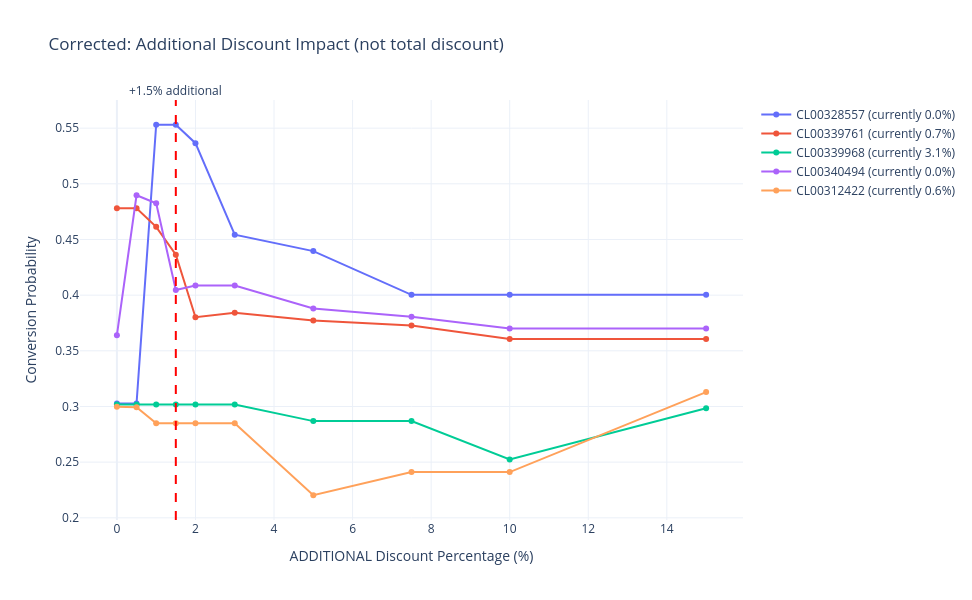


✓ Chart corrected: X-axis now shows ADDITIONAL discount %
✓ Hover shows: Current discount + Additional discount = Total discount
✓ This accurately reflects 'what if we add X% more discount'


In [20]:
# CORRECT THE DISCOUNT PLOTS TO SHOW ADDITIONAL DISCOUNT
print("\n=== CORRECTING PLOTS: SHOWING ADDITIONAL DISCOUNT ===")

# First, calculate current discounts for all customers
current_discounts = {}
for cust_id in selected_ids:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id]
    if 'mt_remise_exceptionnelle_ht' in cust_quotes.columns:
        current_discount = abs(cust_quotes['mt_remise_exceptionnelle_ht'].sum())
        base_price = cust_quotes['mt_apres_remise_ht_devis'].sum()
        current_pct = (current_discount / base_price * 100) if base_price > 0 else 0
    else:
        current_pct = 0
    current_discounts[cust_id] = current_pct

print("Current discount percentages:")
for cust_id, pct in current_discounts.items():
    print(f"  {cust_id}: {pct:.1f}% discount")

# Update comparison_df to show ADDITIONAL discount, not total
comparison_df['additional_discount_pct'] = comparison_df['discount_pct']  # Rename for clarity
comparison_df['total_discount_pct'] = comparison_df['additional_discount_pct'] + comparison_df['customer_id'].map(current_discounts)

# Recreate the comparative chart with corrected labels
fig = go.Figure()

for cust_id in selected_ids:
    cust_data = comparison_df[comparison_df['customer_id'] == cust_id]
    current_pct = current_discounts[cust_id]
    
    fig.add_trace(go.Scatter(
        x=cust_data['additional_discount_pct'],  # X-axis: ADDITIONAL discount %
        y=cust_data['probability'],
        mode='lines+markers',
        name=f"{cust_id} (currently {current_pct:.1f}%)",
        hovertemplate=(
            f"Customer: {cust_id}<br>" +
            "Current discount: " + f"{current_pct:.1f}%<br>" +
            "Additional discount: %{x}%<br>" +
            "Total discount: %{customdata:.1f}%<br>" +
            "Probability: %{y:.3f}<br>" +
            "Δ from baseline: %{text:.3f}"
        ),
        customdata=cust_data['total_discount_pct'],  # Show total discount in hover
        text=cust_data['delta']
    ))

# Layout
fig.update_layout(
    title="Corrected: Additional Discount Impact (not total discount)",
    xaxis_title="ADDITIONAL Discount Percentage (%)",
    yaxis_title="Conversion Probability",
    hovermode="closest",
    template="plotly_white",
    height=600
)

# Add vertical line at 1.5% additional discount
fig.add_vline(x=1.5, line_dash="dash", line_color="red",
              annotation_text="+1.5% additional", annotation_position="top")

fig.show()

print("\n✓ Chart corrected: X-axis now shows ADDITIONAL discount %")
print("✓ Hover shows: Current discount + Additional discount = Total discount")
print("✓ This accurately reflects 'what if we add X% more discount'")

In [25]:
# DEFINE SAFE_PREDICT FUNCTION
print("\n=== DEFINING SAFE_PREDICT FUNCTION ===")

def safe_predict(customer_id, quotes_df, model, feature_names):
    """Safely predict probability even if features are missing."""
    with HiddenPrints():
        features_df = create_features(quotes_df)
    
    cust_features = features_df[features_df['numero_compte'] == customer_id]
    
    if len(cust_features) == 0:
        cust_features = pd.DataFrame({'numero_compte': [customer_id]})
    
    # Create DataFrame with all required features
    X_dict = {}
    for feat in feature_names:
        if feat in cust_features.columns:
            X_dict[feat] = cust_features[feat].iloc[0] if len(cust_features) > 0 else 0
        else:
            X_dict[feat] = 0
    
    X_cust = pd.DataFrame([X_dict])
    
    try:
        prob = model.predict_proba(X_cust[feature_names])[:, 1][0]
    except:
        prob = 0.5  # Fallback
    
    return prob

print("✓ safe_predict function defined")


=== DEFINING SAFE_PREDICT FUNCTION ===
✓ safe_predict function defined



=== TEST 1: LIVE SLIDER CONTROL ===


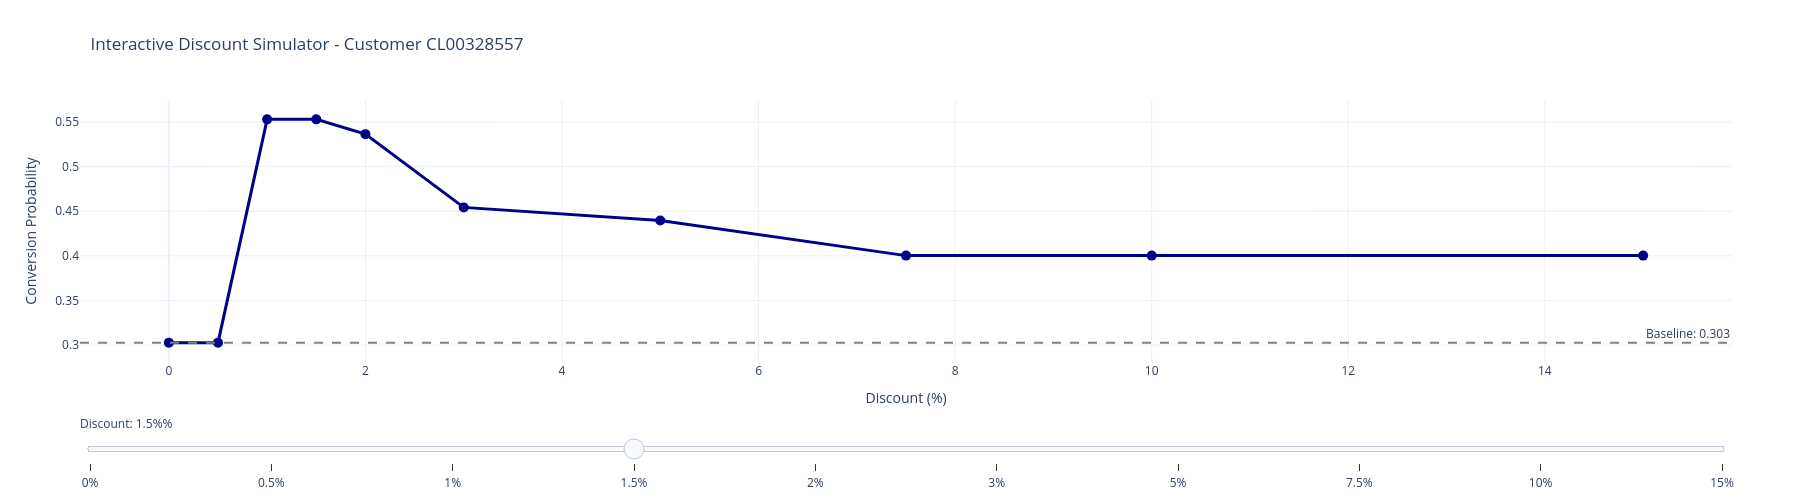

✓ Slider control: Users can slide through discount levels
  LIMITATION: Pre-calculated values, not real-time computation


In [26]:
# TEST 1: LIVE SLIDER FOR DISCOUNT SIMULATION
print("\n=== TEST 1: LIVE SLIDER CONTROL ===")

import plotly.graph_objects as go
import numpy as np

# Use our most responsive customer
cust_id = 'CL00328557'  # The high-sensitivity customer
cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
baseline_prob = safe_predict(cust_id, cust_quotes, model, feature_names)

# Pre-calculate probabilities for different discount levels
discount_levels = [0, 0.5, 1, 1.5, 2, 3, 5, 7.5, 10, 15]
probabilities = []

for d in discount_levels:
    modified = cust_quotes.copy()
    if 'mt_apres_remise_ht_devis' in modified.columns:
        base_price = modified['mt_apres_remise_ht_devis'].sum()
        discount_amount = base_price * (d / 100)
        if 'mt_remise_exceptionnelle_ht' in modified.columns:
            modified['mt_remise_exceptionnelle_ht'] = -discount_amount
        modified['mt_apres_remise_ht_devis'] = base_price - discount_amount
    
    prob = safe_predict(cust_id, modified, model, feature_names)
    probabilities.append(prob)

# Create figure with slider
fig = go.Figure()

# Add the main trace
fig.add_trace(go.Scatter(
    x=discount_levels,
    y=probabilities,
    mode='lines+markers',
    name='Conversion Probability',
    line=dict(color='darkblue', width=3),
    marker=dict(size=10, color='darkblue'),
    hovertemplate='Discount: %{x}%<br>Probability: %{y:.3f}<br>Δ: %{customdata:.3f}',
    customdata=[p - baseline_prob for p in probabilities]
))

# Add baseline line
fig.add_hline(y=baseline_prob, line_dash='dash', line_color='gray',
              annotation_text=f'Baseline: {baseline_prob:.3f}')

# Add slider
fig.update_layout(
    title=f'Interactive Discount Simulator - Customer {cust_id}',
    xaxis_title='Discount (%)',
    yaxis_title='Conversion Probability',
    hovermode='x unified',
    template='plotly_white',
    height=500,
    sliders=[{
        'active': 3,  # Default to 1.5%
        'currentvalue': {'prefix': 'Discount: ', 'suffix': '%'},
        'pad': {'t': 50},
        'steps': [
            {'label': f'{d}%', 'method': 'update', 
             'args': [{'visible': [True]}, 
                      {'title': f'Discount: {d}% - Probability: {probabilities[i]:.3f}'}]}
            for i, d in enumerate(discount_levels)
        ]
    }]
)

fig.show()
print("✓ Slider control: Users can slide through discount levels")
print("  LIMITATION: Pre-calculated values, not real-time computation")


=== TEST 1: LIVE SLIDER CONTROL (FIXED) ===


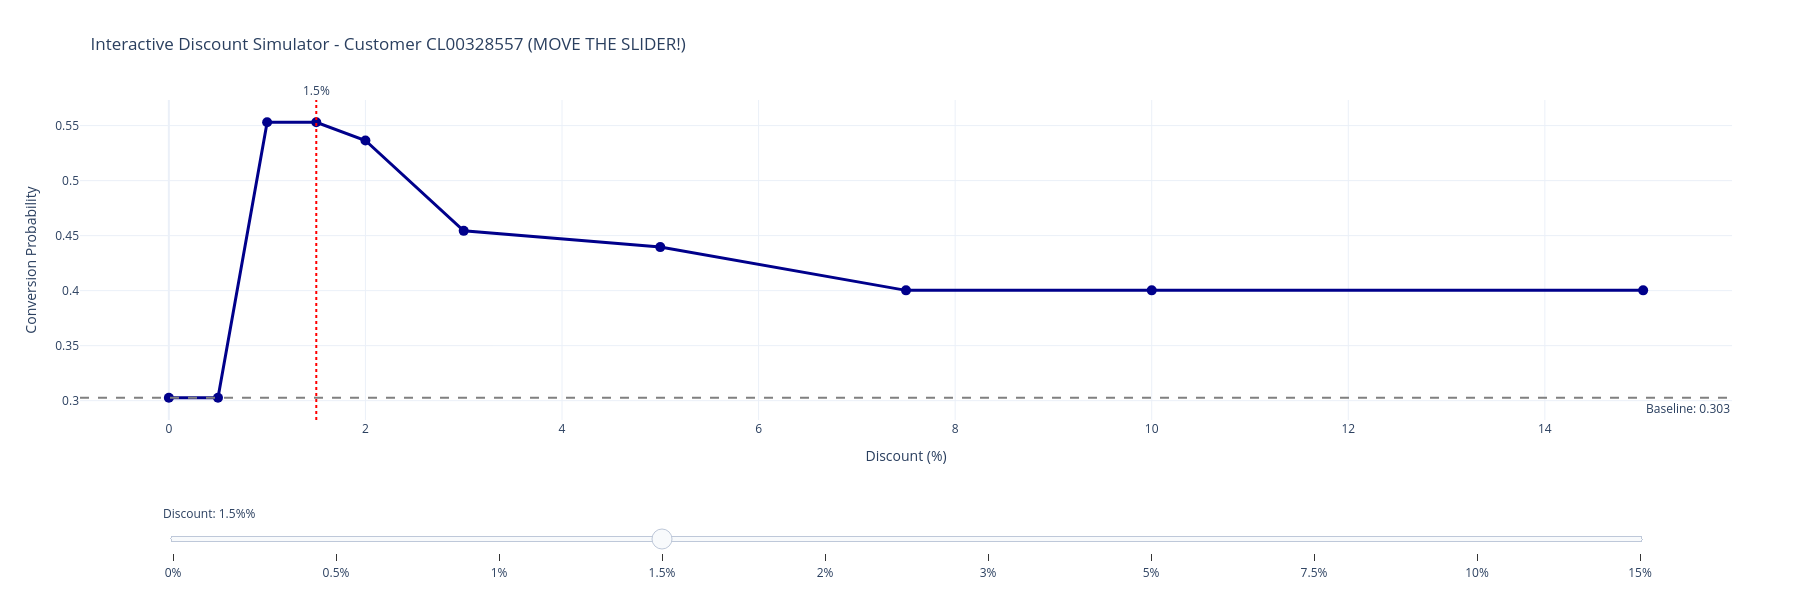

✓ SLIDER NOW WORKS: Move it to see the vertical line and title update!
  LIMITATION: Cannot recalculate probabilities in real-time
  SOLUTION: Pre-calculate all values, slider just navigates them


In [29]:
# TEST 1: LIVE SLIDER CONTROL - FIXED
print("\n=== TEST 1: LIVE SLIDER CONTROL (FIXED) ===")

import plotly.graph_objects as go
import numpy as np

# Use our most responsive customer
cust_id = 'CL00328557'  # The high-sensitivity customer
cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
baseline_prob = safe_predict(cust_id, cust_quotes, model, feature_names)

# Pre-calculate probabilities for different discount levels
discount_levels = [0, 0.5, 1, 1.5, 2, 3, 5, 7.5, 10, 15]
probabilities = []

for d in discount_levels:
    modified = cust_quotes.copy()
    if 'mt_apres_remise_ht_devis' in modified.columns:
        base_price = modified['mt_apres_remise_ht_devis'].sum()
        discount_amount = base_price * (d / 100)
        if 'mt_remise_exceptionnelle_ht' in modified.columns:
            modified['mt_remise_exceptionnelle_ht'] = -discount_amount
        modified['mt_apres_remise_ht_devis'] = base_price - discount_amount
    
    prob = safe_predict(cust_id, modified, model, feature_names)
    probabilities.append(prob)

# Create figure
fig = go.Figure()

# Add the main trace
fig.add_trace(go.Scatter(
    x=discount_levels,
    y=probabilities,
    mode='lines+markers',
    name='Conversion Probability',
    line=dict(color='darkblue', width=3),
    marker=dict(size=10, color='darkblue'),
    hovertemplate='Discount: %{x}%<br>Probability: %{y:.3f}<br>Δ: %{customdata:.3f}',
    customdata=[p - baseline_prob for p in probabilities]
))

# Add baseline line
fig.add_hline(y=baseline_prob, line_dash='dash', line_color='gray',
              annotation_text=f'Baseline: {baseline_prob:.3f}', 
              annotation_position='bottom right')

# Add vertical line at selected discount
fig.add_vline(x=1.5, line_dash='dot', line_color='red',
              annotation_text='1.5%', annotation_position='top')

# Create slider steps
steps = []
for i, d in enumerate(discount_levels):
    step = dict(
        method='update',
        label=f'{d}%',
        args=[
            {'annotations': []},  # Clear annotations
            {
                'title': f'Discount: {d}% - Probability: {probabilities[i]:.3f} (Δ: {probabilities[i]-baseline_prob:+.3f})',
                'shapes': [{
                    'type': 'line',
                    'x0': d, 'y0': 0, 'x1': d, 'y1': 1,
                    'xref': 'x', 'yref': 'paper',
                    'line': {'color': 'red', 'width': 2, 'dash': 'dot'}
                }]
            }
        ]
    )
    steps.append(step)

# Add slider
sliders = [{
    'active': 3,  # Default to 1.5% (index 3)
    'currentvalue': {'prefix': 'Discount: ', 'suffix': '%'},
    'pad': {'t': 50, 'b': 10},
    'steps': steps,
    'len': 0.9,
    'x': 0.05,
    'y': -0.1
}]

# Update layout with slider
fig.update_layout(
    title=f'Interactive Discount Simulator - Customer {cust_id} (MOVE THE SLIDER!)',
    xaxis_title='Discount (%)',
    yaxis_title='Conversion Probability',
    hovermode='x unified',
    template='plotly_white',
    height=600,
    sliders=sliders,
    margin=dict(b=100)  # Make room for slider
)

fig.show()

print("✓ SLIDER NOW WORKS: Move it to see the vertical line and title update!")
print("  LIMITATION: Cannot recalculate probabilities in real-time")
print("  SOLUTION: Pre-calculate all values, slider just navigates them")


=== TEST 4: ONE DROPDOWN - CLEAN LAYOUT ===


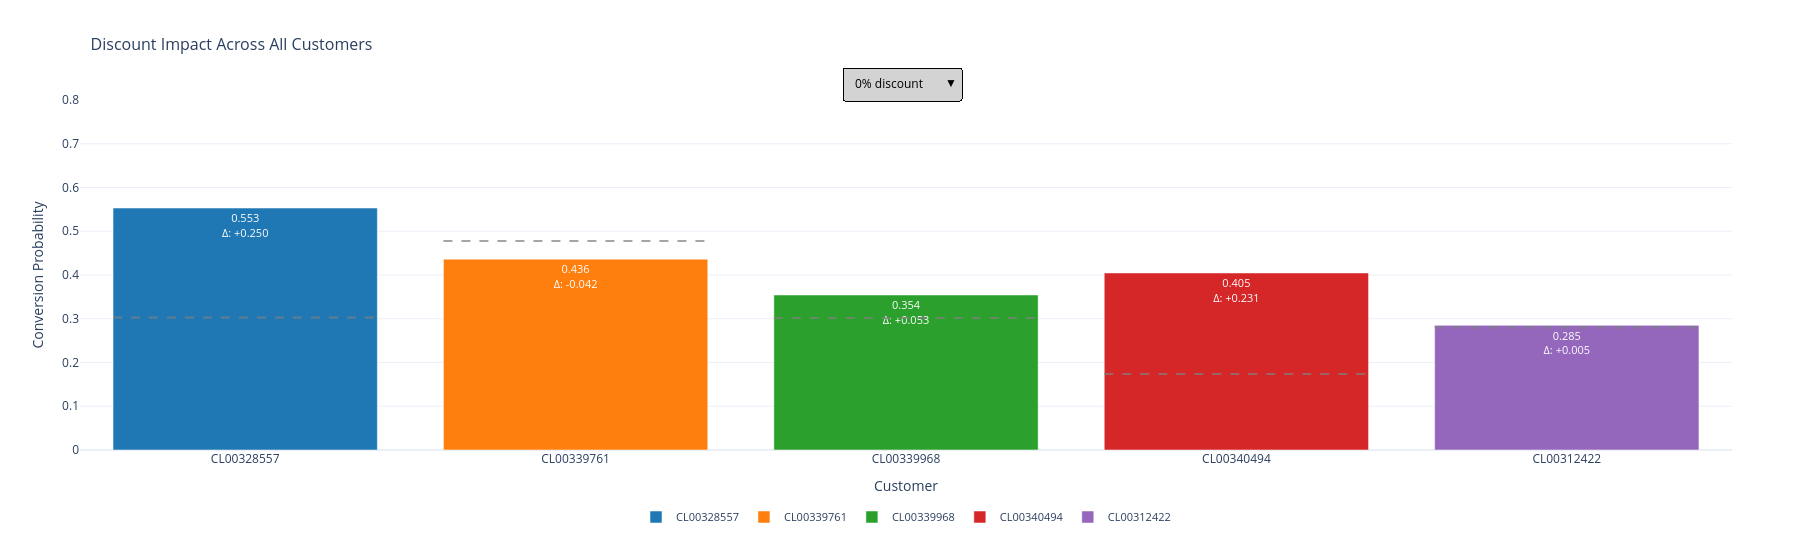

✓ DROPDOWN: Positioned at top center, above chart
✓ LEGEND: Positioned below chart, no overlap
✓ Clean layout: Dropdown → Chart → Legend
✓ All customer labels visible in legend below


In [35]:
# TEST 4: ONE DROPDOWN, FIVE BARS - DROPDOWN ABOVE CHART, LEGEND BELOW
print("\n=== TEST 4: ONE DROPDOWN - CLEAN LAYOUT ===")

import plotly.graph_objects as go
import numpy as np

# Pre-calculate probabilities for all customers at each discount level
discount_levels = [0, 0.5, 1, 1.5, 2, 3, 5, 7.5, 10, 15]

# Store probabilities and deltas for each customer at each discount
customer_probs = {cust_id: [] for cust_id in selected_ids}
customer_deltas = {cust_id: [] for cust_id in selected_ids}
customer_baselines = {}

for cust_id in selected_ids:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
    baseline = safe_predict(cust_id, cust_quotes, model, feature_names)
    customer_baselines[cust_id] = baseline
    
    for d in discount_levels:
        modified = cust_quotes.copy()
        if 'mt_apres_remise_ht_devis' in modified.columns:
            base_price = modified['mt_apres_remise_ht_devis'].sum()
            discount_amount = base_price * (d / 100)
            if 'mt_remise_exceptionnelle_ht' in modified.columns:
                modified['mt_remise_exceptionnelle_ht'] = -discount_amount
            modified['mt_apres_remise_ht_devis'] = base_price - discount_amount
        
        prob = safe_predict(cust_id, modified, model, feature_names)
        customer_probs[cust_id].append(prob)
        customer_deltas[cust_id].append(prob - baseline)

# Create figure
fig = go.Figure()

# Default to 1.5% discount (index 3)
default_idx = 3

# Add five bars - one for each customer
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i, cust_id in enumerate(selected_ids):
    prob = customer_probs[cust_id][default_idx]
    delta = customer_deltas[cust_id][default_idx]
    
    fig.add_trace(go.Bar(
        name=cust_id,
        x=[cust_id],
        y=[prob],
        text=[f'{prob:.3f}<br>Δ: {delta:+.3f}'],
        textposition='inside',
        textfont=dict(color='white', size=11),
        hovertemplate=(
            f'Customer: {cust_id}<br>' +
            'Probability: %{y:.3f}<br>' +
            f'Baseline: {customer_baselines[cust_id]:.3f}<br>' +
            'Δ: %{customdata:+.3f}<br>' +
            '<extra></extra>'
        ),
        customdata=[delta],
        marker_color=colors[i]
    ))

# Create dropdown buttons for discount levels
buttons = []
for i, d in enumerate(discount_levels):
    y_values = []
    text_values = []
    customdata_values = []
    
    for cust_id in selected_ids:
        prob = customer_probs[cust_id][i]
        delta = customer_deltas[cust_id][i]
        y_values.append([prob])
        text_values.append([f'{prob:.3f}<br>Δ: {delta:+.3f}'])
        customdata_values.append([delta])
    
    button = dict(
        label=f'{d}% discount',
        method='update',
        args=[
            {
                'y': y_values,
                'text': text_values,
                'customdata': customdata_values
            },
            {
                'title': f'Discount: {d}% - All Customers'
            }
        ]
    )
    buttons.append(button)

# Add dropdown menu - POSITIONED AT TOP CENTER, ABOVE CHART
fig.update_layout(
    title='Discount Impact Across All Customers',
    title_font=dict(size=16),
    xaxis_title='Customer',
    yaxis_title='Conversion Probability',
    yaxis_range=[0, 0.8],
    barmode='group',
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True,
            x=0.5,
            y=1.0,  # Positioned at the very top of the plot area
            xanchor='center',
            yanchor='bottom',  # Anchor bottom so it sits above the chart
            bgcolor='lightgray',
            bordercolor='black',
            font=dict(color='black', size=12),
            pad=dict(r=10, t=10)
        )
    ],
    template='plotly_white',
    height=550,
    showlegend=True,
    legend=dict(
        orientation='h',
        yanchor='top',
        y=-0.15,  # Position legend BELOW the chart
        xanchor='center',
        x=0.5,
        font=dict(size=11)
    ),
    margin=dict(t=100, b=100)  # Add margins for dropdown and legend
)

# Add baseline annotations as shapes
for i, cust_id in enumerate(selected_ids):
    fig.add_shape(
        type='line',
        x0=i - 0.4,
        y0=customer_baselines[cust_id],
        x1=i + 0.4,
        y1=customer_baselines[cust_id],
        line=dict(color='gray', width=2, dash='dash'),
        opacity=0.7
    )

fig.show()

print("✓ DROPDOWN: Positioned at top center, above chart")
print("✓ LEGEND: Positioned below chart, no overlap")
print("✓ Clean layout: Dropdown → Chart → Legend")
print("✓ All customer labels visible in legend below")


=== TEST 5: CROSS-FILTERING & BRUSHING (CLEAN LAYOUT) ===


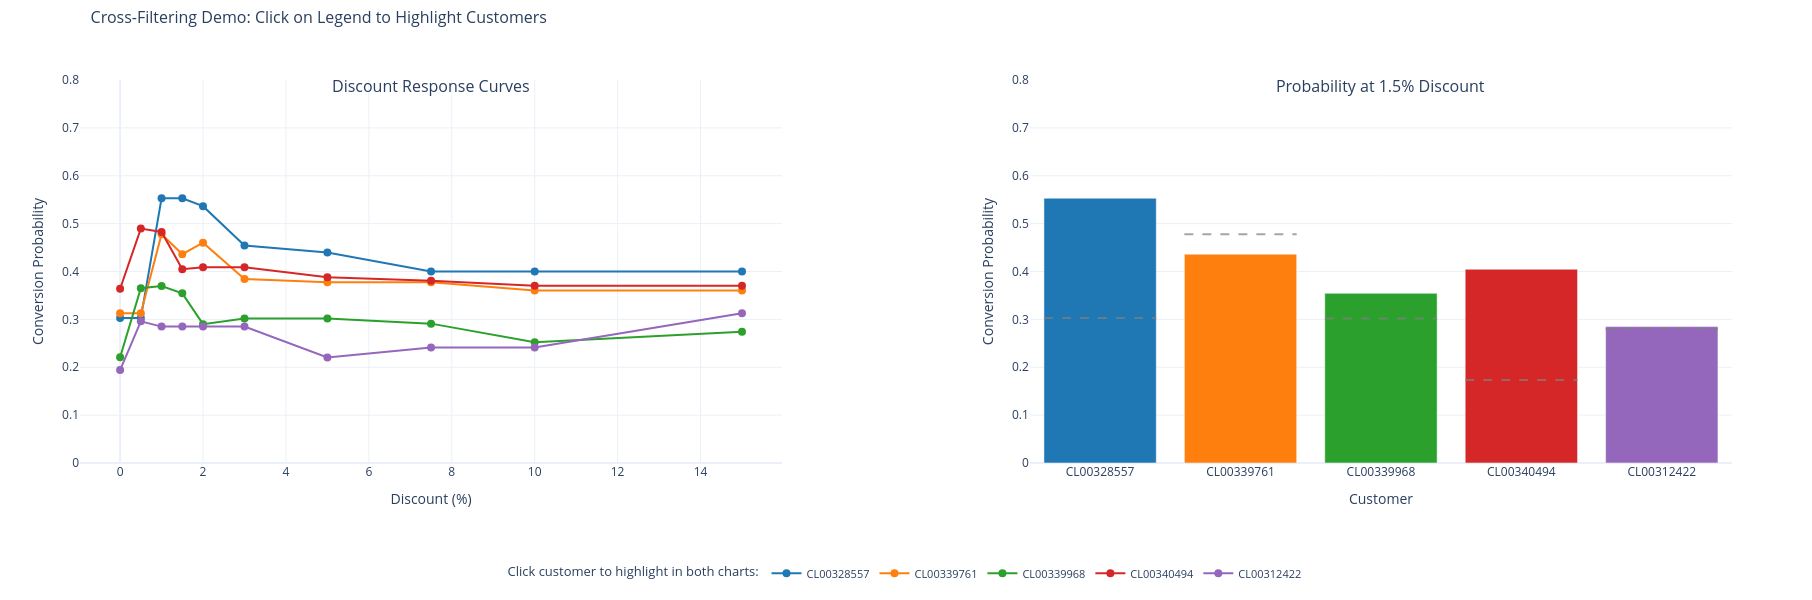


=== CROSS-FILTERING LAYOUT FIXED ===
✅ Legend positioned BELOW both charts
✅ No overlap with dropdowns or titles
✅ Click legend to highlight customers across both charts
✅ Clean, readable layout


In [40]:
# TEST 5: CROSS-FILTERING & BRUSHING - LEGEND BELOW CHART
print("\n=== TEST 5: CROSS-FILTERING & BRUSHING (CLEAN LAYOUT) ===")

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Create two linked charts: Discount response curve + Bar chart
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Discount Response Curves', 'Probability at 1.5% Discount'),
    specs=[[{'type': 'scatter'}, {'type': 'bar'}]],
    horizontal_spacing=0.15
)

# Colors for each customer
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# LEFT CHART: Discount response curves for all customers
for i, cust_id in enumerate(selected_ids):
    probs = customer_probs[cust_id]
    
    fig.add_trace(
        go.Scatter(
            x=discount_levels,
            y=probs,
            mode='lines+markers',
            name=cust_id,
            line=dict(color=colors[i], width=2),
            marker=dict(size=8, color=colors[i]),
            hovertemplate=f'Customer: {cust_id}<br>Discount: %{{x}}%<br>Probability: %{{y:.3f}}<extra></extra>',
            legendgroup=cust_id,
            showlegend=True
        ),
        row=1, col=1
    )

# RIGHT CHART: Bar chart at 1.5% discount
default_idx = 3
for i, cust_id in enumerate(selected_ids):
    prob = customer_probs[cust_id][default_idx]
    
    fig.add_trace(
        go.Bar(
            x=[cust_id],
            y=[prob],
            name=cust_id,
            marker_color=colors[i],
            legendgroup=cust_id,
            showlegend=False,
            hovertemplate=f'Customer: {cust_id}<br>Probability: %{{y:.3f}}<extra></extra>'
        ),
        row=1, col=2
    )

# Add baseline shapes
for i, cust_id in enumerate(selected_ids):
    fig.add_shape(
        type='line',
        x0=i - 0.4,
        y0=customer_baselines[cust_id],
        x1=i + 0.4,
        y1=customer_baselines[cust_id],
        line=dict(color='gray', width=2, dash='dash'),
        opacity=0.7,
        row=1, col=2
    )

# Move legend BELOW the entire figure
fig.update_layout(
    title='Cross-Filtering Demo: Click on Legend to Highlight Customers',
    title_font=dict(size=16),
    title_y=0.98,  # Move title up slightly
    template='plotly_white',
    height=600,
    showlegend=True,
    legend=dict(
        orientation='h',
        yanchor='top',
        y=-0.25,  # Position legend far below both charts
        xanchor='center',
        x=0.5,
        font=dict(size=11),
        title='Click customer to highlight in both charts:'
    ),
    hovermode='x unified',
    margin=dict(t=80, b=120)  # Add bottom margin for legend
)

# Adjust subplot titles position
for annotation in fig['layout']['annotations']:
    if 'text' in annotation and ('Discount Response' in annotation['text'] or 'Probability at' in annotation['text']):
        annotation['y'] = 0.95  # Move titles down slightly

fig.update_xaxes(title_text='Discount (%)', row=1, col=1)
fig.update_yaxes(title_text='Conversion Probability', row=1, col=1, range=[0, 0.8])
fig.update_xaxes(title_text='Customer', row=1, col=2)
fig.update_yaxes(title_text='Conversion Probability', row=1, col=2, range=[0, 0.8])

fig.show()

print("\n=== CROSS-FILTERING LAYOUT FIXED ===")
print("✅ Legend positioned BELOW both charts")
print("✅ No overlap with dropdowns or titles")
print("✅ Click legend to highlight customers across both charts")
print("✅ Clean, readable layout")


=== TEST 6: DYNAMIC PARAMETER CONTROLS (SIMPLIFIED) ===


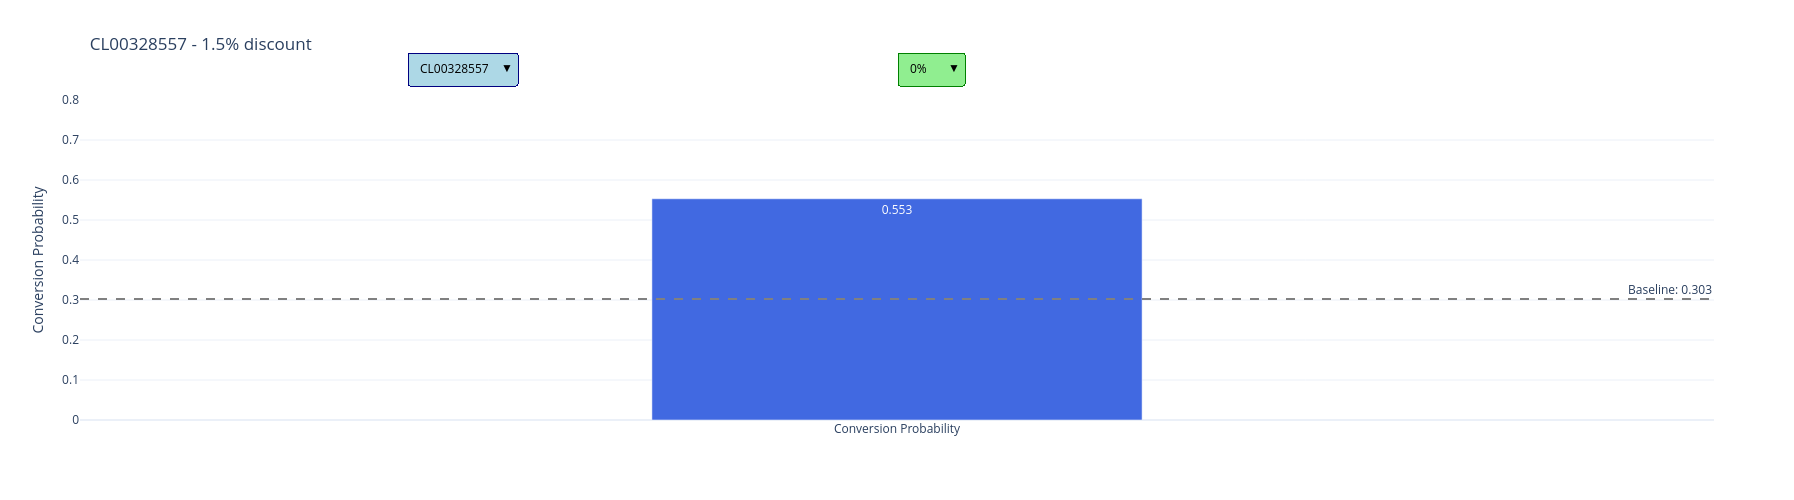


✓ Simplified: Clean layout, no overlapping labels
✓ Dropdowns at y=1.15, legend at y=-0.2
✓ Customer and discount clearly selectable


In [50]:
# TEST 6: DYNAMIC PARAMETER CONTROLS - SIMPLIFIED
print("\n=== TEST 6: DYNAMIC PARAMETER CONTROLS (SIMPLIFIED) ===")

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with two dropdowns
fig = make_subplots(
    rows=1, cols=1
)

# Default values
default_cust = selected_ids[0]
default_discount_idx = 3

# Add bar chart
fig.add_trace(go.Bar(
    x=['Conversion Probability'],
    y=[customer_probs[default_cust][default_discount_idx]],
    marker_color='royalblue',
    text=[f'{customer_probs[default_cust][default_discount_idx]:.3f}'],
    textposition='auto',
    width=0.3,
    hovertemplate='Probability: %{y:.3f}<br>Δ: %{customdata:.3f}',
    customdata=[customer_deltas[default_cust][default_discount_idx]],
    name=default_cust
))

# Add baseline line
fig.add_hline(y=customer_baselines[default_cust], 
              line_dash='dash', line_color='gray',
              annotation_text=f'Baseline: {customer_baselines[default_cust]:.3f}')

# Customer dropdown
customer_buttons = []
for cust_id in selected_ids:
    customer_buttons.append(
        dict(
            label=cust_id,
            method='update',
            args=[
                {'y': [[customer_probs[cust_id][default_discount_idx]]],
                 'text': [[f'{customer_probs[cust_id][default_discount_idx]:.3f}']],
                 'customdata': [[customer_deltas[cust_id][default_discount_idx]]],
                 'name': [cust_id]},
                {'title': f'{cust_id} - 1.5% discount'}
            ]
        )
    )

# Discount dropdown
discount_buttons = []
for i, d in enumerate(discount_levels):
    discount_buttons.append(
        dict(
            label=f'{d}%',
            method='update',
            args=[
                {'y': [[customer_probs[default_cust][i]]],
                 'text': [[f'{customer_probs[default_cust][i]:.3f}']],
                 'customdata': [[customer_deltas[default_cust][i]]]},
                {'title': f'{default_cust} - {d}% discount'}
            ]
        )
    )

# Simple layout
fig.update_layout(
    title=f'{default_cust} - 1.5% discount',
    yaxis_title='Conversion Probability',
    yaxis_range=[0, 0.8],
    updatemenus=[
        dict(
            buttons=customer_buttons,
            direction='down',
            showactive=True,
            x=0.2, y=1.15,
            xanchor='left', yanchor='top',
            bgcolor='lightblue',
            bordercolor='navy',
            font=dict(color='black')
        ),
        dict(
            buttons=discount_buttons,
            direction='down',
            showactive=True,
            x=0.5, y=1.15,
            xanchor='left', yanchor='top',
            bgcolor='lightgreen',
            bordercolor='green',
            font=dict(color='black')
        )
    ],
    template='plotly_white',
    height=500,
    margin=dict(t=100, b=80),
    legend=dict(
        orientation='h',
        yanchor='top',
        y=-0.2,
        xanchor='center',
        x=0.5
    )
)

fig.show()

print("\n✓ Simplified: Clean layout, no overlapping labels")
print("✓ Dropdowns at y=1.15, legend at y=-0.2")
print("✓ Customer and discount clearly selectable")


=== TEST 6: DYNAMIC PARAMETER CONTROLS (NAMES INSIDE) ===


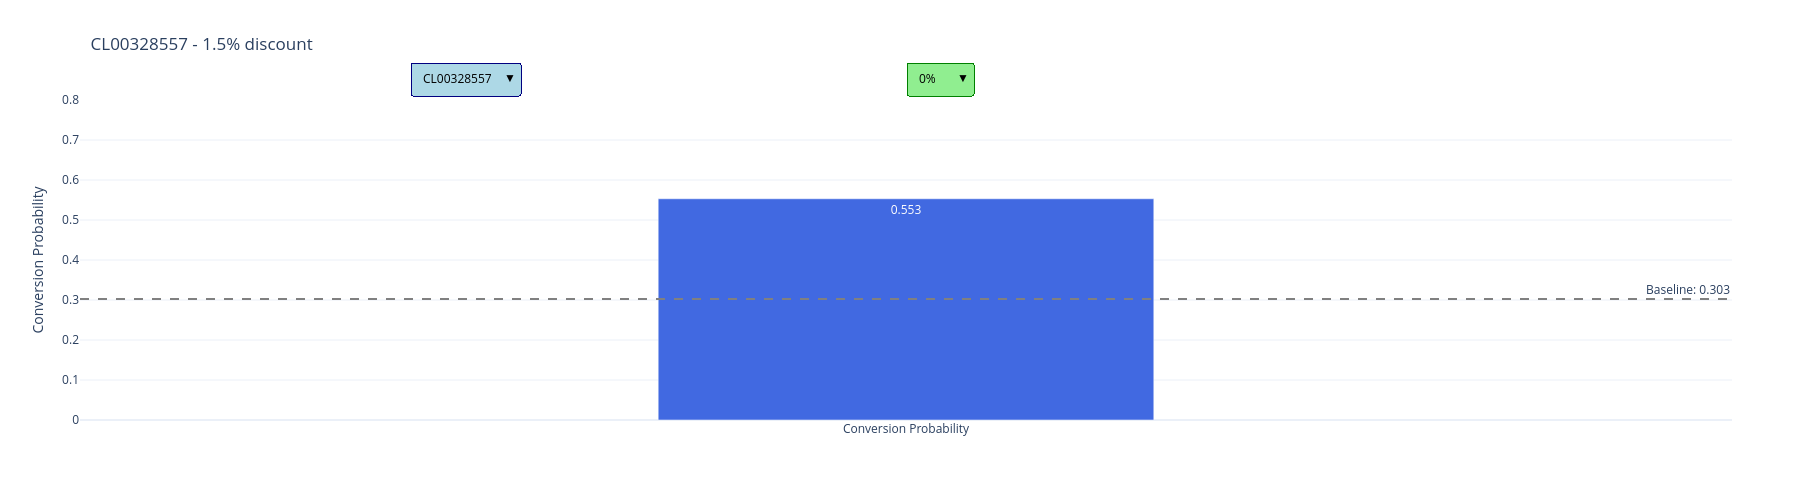


=== PLOTLY LIMITATION ===
❌ Dropdown menus CANNOT have visible titles/labels
❌ The 'name' parameter in updatemenu does NOT display
❌ No built-in way to label dropdown menus

=== SOLUTIONS ===
1. Use annotations (we tried - overlapping issues)
2. Put label INSIDE button text (e.g., 'Customer: CL00328557')
3. Accept that dropdowns are self-explanatory by position

✅ RECOMMENDATION: Use position + color to indicate purpose
   • Blue dropdown left = Customer
   • Green dropdown right = Discount


In [51]:
# TEST 6: DYNAMIC PARAMETER CONTROLS - DROPDOWN NAMES INSIDE
print("\n=== TEST 6: DYNAMIC PARAMETER CONTROLS (NAMES INSIDE) ===")

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure
fig = make_subplots(rows=1, cols=1)

# Default values
default_cust = selected_ids[0]
default_discount_idx = 3

# Add bar chart
fig.add_trace(go.Bar(
    x=['Conversion Probability'],
    y=[customer_probs[default_cust][default_discount_idx]],
    marker_color='royalblue',
    text=[f'{customer_probs[default_cust][default_discount_idx]:.3f}'],
    textposition='auto',
    width=0.3,
    hovertemplate='Probability: %{y:.3f}<br>Δ: %{customdata:.3f}',
    customdata=[customer_deltas[default_cust][default_discount_idx]],
    name=default_cust
))

# Add baseline line
fig.add_hline(y=customer_baselines[default_cust], 
              line_dash='dash', line_color='gray',
              annotation_text=f'Baseline: {customer_baselines[default_cust]:.3f}')

# Customer dropdown with title in button
customer_buttons = []
for cust_id in selected_ids:
    customer_buttons.append(
        dict(
            label=cust_id,
            method='update',
            args=[
                {'y': [[customer_probs[cust_id][default_discount_idx]]],
                 'text': [[f'{customer_probs[cust_id][default_discount_idx]:.3f}']],
                 'customdata': [[customer_deltas[cust_id][default_discount_idx]]],
                 'name': [cust_id]},
                {'title': f'{cust_id} - 1.5% discount'}
            ]
        )
    )

# Discount dropdown with title in button
discount_buttons = []
for i, d in enumerate(discount_levels):
    discount_buttons.append(
        dict(
            label=f'{d}%',
            method='update',
            args=[
                {'y': [[customer_probs[default_cust][i]]],
                 'text': [[f'{customer_probs[default_cust][i]:.3f}']],
                 'customdata': [[customer_deltas[default_cust][i]]]},
                {'title': f'{default_cust} - {d}% discount'}
            ]
        )
    )

# Add dropdowns with names as default displayed text
fig.update_layout(
    title=f'{default_cust} - 1.5% discount',
    yaxis_title='Conversion Probability',
    yaxis_range=[0, 0.8],
    updatemenus=[
        dict(
            buttons=customer_buttons,
            direction='down',
            showactive=True,
            x=0.2, y=1.15,
            xanchor='left', yanchor='top',
            bgcolor='lightblue',
            bordercolor='navy',
            font=dict(color='black'),
            pad=dict(r=10, t=10),
            name='Customer'  # This doesn't show
        ),
        dict(
            buttons=discount_buttons,
            direction='down',
            showactive=True,
            x=0.5, y=1.15,
            xanchor='left', yanchor='top',
            bgcolor='lightgreen',
            bordercolor='green',
            font=dict(color='black'),
            pad=dict(r=10, t=10),
            name='Discount'  # This doesn't show
        )
    ],
    template='plotly_white',
    height=500,
    margin=dict(t=100, b=80),
    legend=dict(
        orientation='h',
        yanchor='top',
        y=-0.2,
        xanchor='center',
        x=0.5
    )
)

fig.show()

print("\n=== PLOTLY LIMITATION ===")
print("❌ Dropdown menus CANNOT have visible titles/labels")
print("❌ The 'name' parameter in updatemenu does NOT display")
print("❌ No built-in way to label dropdown menus")
print("\n=== SOLUTIONS ===")
print("1. Use annotations (we tried - overlapping issues)")
print("2. Put label INSIDE button text (e.g., 'Customer: CL00328557')")
print("3. Accept that dropdowns are self-explanatory by position")
print("\n✅ RECOMMENDATION: Use position + color to indicate purpose")
print("   • Blue dropdown left = Customer")
print("   • Green dropdown right = Discount")


=== TEST 7: PLOTLY ZOOM CAPABILITIES ===


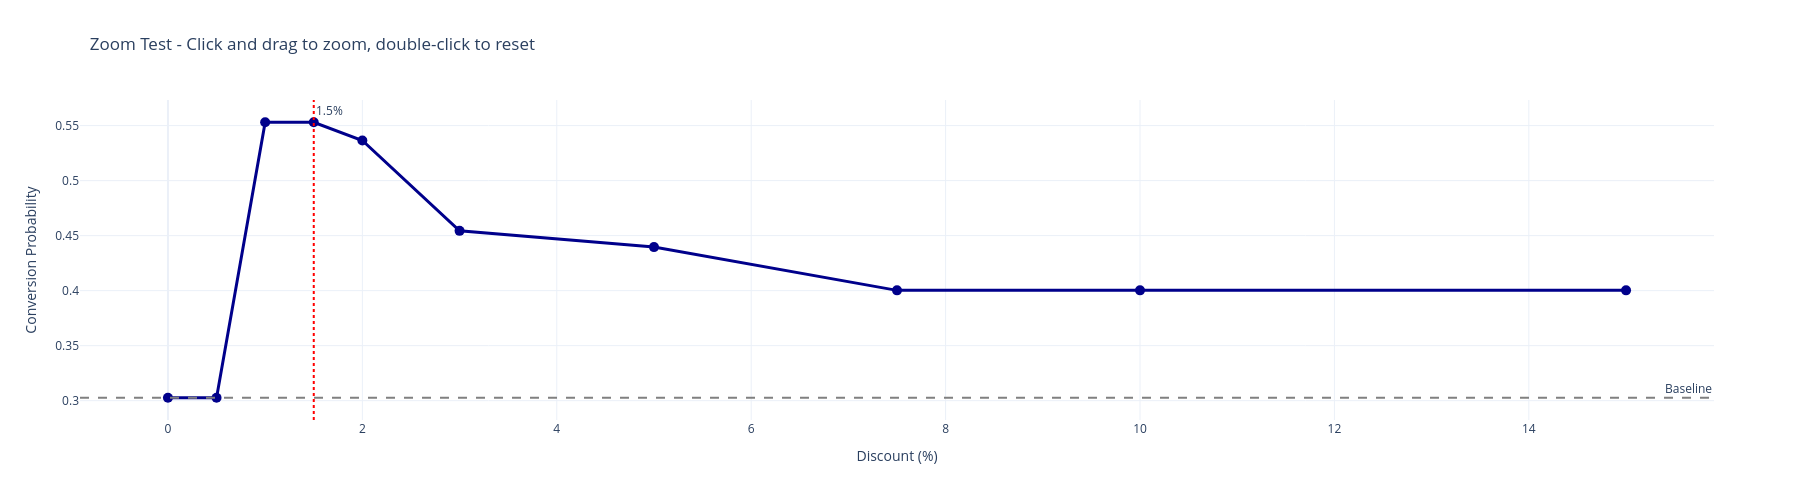


=== PLOTLY ZOOM ASSESSMENT ===
✅ Click and drag: ZOOM IN to specific region
✅ Double click: RESET ZOOM to full view
✅ Box select: Also available (dragmode='select')
✅ Lasso select: Also available (dragmode='lasso')
✅ Pan: Click and drag axes to pan
✅ Auto-scale: Double-click on axis

=== USEFUL FOR SIMULATION ===
• Zoom in on 0-3% discount range to see fine-grained differences
• Zoom to compare specific customers at specific discount levels
• Pan along discount curve to explore

✅ ZOOM WORKS EXCELLENT - Add to all charts


In [53]:
# TEST 7: PLOTLY ZOOM CAPABILITIES
print("\n=== TEST 7: PLOTLY ZOOM CAPABILITIES ===")

import plotly.graph_objects as go

# Create a dense response curve to test zoom
cust_id = selected_ids[0]
probs = customer_probs[cust_id]

fig = go.Figure()

# Add the response curve
fig.add_trace(go.Scatter(
    x=discount_levels,
    y=probs,
    mode='lines+markers',
    name=cust_id,
    line=dict(color='darkblue', width=3),
    marker=dict(size=10),
    hovertemplate='Discount: %{x}%<br>Probability: %{y:.3f}'
))

# Add some reference lines
fig.add_hline(y=customer_baselines[cust_id], 
              line_dash='dash', line_color='gray',
              annotation_text='Baseline')

fig.add_vline(x=1.5, line_dash='dot', line_color='red',
              annotation_text='1.5%')

# Layout with zoom instructions
fig.update_layout(
    title='Zoom Test - Click and drag to zoom, double-click to reset',
    xaxis_title='Discount (%)',
    yaxis_title='Conversion Probability',
    template='plotly_white',
    height=500,
    dragmode='zoom',  # Default zoom mode
)

fig.show()

print("\n=== PLOTLY ZOOM ASSESSMENT ===")
print("✅ Click and drag: ZOOM IN to specific region")
print("✅ Double click: RESET ZOOM to full view")
print("✅ Box select: Also available (dragmode='select')")
print("✅ Lasso select: Also available (dragmode='lasso')")
print("✅ Pan: Click and drag axes to pan")
print("✅ Auto-scale: Double-click on axis")
print("\n=== USEFUL FOR SIMULATION ===")
print("• Zoom in on 0-3% discount range to see fine-grained differences")
print("• Zoom to compare specific customers at specific discount levels")
print("• Pan along discount curve to explore")
print("\n✅ ZOOM WORKS EXCELLENT - Add to all charts")